# Assign RegulatoryOverlayUUIDs Values to Water Right sites.csv
Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.

Notes: 
- requires the completed pre-processed sites.csv & watersource.csv files from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.  Rename to wr_sites.csv & wr_watersource.csv to preserve inputs.
- requires awareness of unique WaterSourceTypeCV of each water right site match up to corresponding WaterSourceTypeCV of regulatoryoverlays per reportingunits

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/Wyoming/Regulatory" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/Wyoming/Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right #A (Wyoming Water Development Office) Input Data
dfwsA = pd.read_csv('ProcessedInputData/wrA_watersources.csv')
dfsA = pd.read_csv('ProcessedInputData/wrA_sites.csv', engine = "python", error_bad_lines=False)

# Water right #B (Wyoming State Geological Survey) Input Data
dfwsB = pd.read_csv('ProcessedInputData/wrB_watersources.csv')
dfsB = pd.read_csv('ProcessedInputData/wrB_sites.csv', engine = "python", error_bad_lines=False)

C:\Users\rjame\AppData\Local\Temp\ipykernel_9916\448220084.py:8: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfsA = pd.read_csv('ProcessedInputData/wrA_sites.csv', engine = "python", error_bad_lines=False)
C:\Users\rjame\AppData\Local\Temp\ipykernel_9916\448220084.py:12: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dfsB = pd.read_csv('ProcessedInputData/wrB_sites.csv', engine = "python", error_bad_lines=False)


In [4]:
#### regulatory watersource info with reporting unit info

# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Surface and Groundwater']
35


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,WYre_RUwy1,4326,Campbell County Conservation,wy1,NaN,Conservation Districts,7/30/2023,WY,POLYGON ((-106.01895941400703 43.7119056633044...,WYre_RO1,Surface and Groundwater


In [5]:
#### water right A (Wyoming Water Development Office) watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfsA = dfsA.assign(WaterSourceUUIDs=dfsA['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfsA via WaterSourceUUIDs -to -WaterSourceUUID
dfsA = pd.merge(dfsA, dfwsA[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfsA['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfsA))
dfsA.head(1)

['Groundwater' 'Surface Water' 'WaDE Blank']
71633


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WYwr_SwadeID1,NaN,WYwr_WSwadeID1,WaDE Blank,WaDE Blank,WaDE Blank,4326,NaN,NaN,NaN,NaN,42.91290,-104.46127,NaN,NaN,POD,O W Well #1,wadeID1,NaN,Well,WY,NaN,WYwr_WSwadeID1,Groundwater


In [6]:
#### water right B (Wyoming State Geological Survey) watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfsB = dfsB.assign(WaterSourceUUIDs=dfsB['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfsB via WaterSourceUUIDs -to -WaterSourceUUID
dfsB = pd.merge(dfsB, dfwsB[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfsB['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfsB))
dfsB.head(1)

['Groundwater' 'Surface Water']
109868


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WSGSwr_SPOD,NaN,WSGSwr_WSwadeID1,WaDE Blank,Digitized,WaDE Blank,4326,NaN,NaN,NaN,NaN,44.67044,-107.02211,NaN,NaN,POD,Benen Spring No 1,POD,NaN,Spring,WY,NaN,WSGSwr_WSwadeID1,Groundwater


In [7]:
#### water right watersoruce and site info
frames = [dfsA, dfsB] # add geoutdf dataframes here
dfs = pd.concat(frames).reset_index(drop=True)
print(len(dfs))
dfs.head(1)

181501


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WYwr_SwadeID1,NaN,WYwr_WSwadeID1,WaDE Blank,WaDE Blank,WaDE Blank,4326,NaN,NaN,NaN,NaN,42.91290,-104.46127,NaN,NaN,POD,O W Well #1,wadeID1,NaN,Well,WY,NaN,WYwr_WSwadeID1,Groundwater


## Extract RegulatoryOverlay from Reporting Units and assing to WR Sites
- repeat scripts based on the number of ReportingUnitTypeCV types.
- merge all geo-dataframes into one output

#### Regulatory Area Data #1

In [8]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV

dfru1 = dfru.copy()
nameOfReportingUnitTypeVar = "Conservation Districts" # change here for ReportingUnitTypeCV of interest
dfru1 = dfru1[dfru1['ReportingUnitTypeCV'] == nameOfReportingUnitTypeVar]
print(len(dfru1))
print(dfru1['WaterSourceTypeCV'].unique())
dfru1.head(1)

35
['Surface and Groundwater']


,ReportingUnitUUID,EPSGCodeCV,ReportingUnitName,ReportingUnitNativeID,ReportingUnitProductVersion,ReportingUnitTypeCV,ReportingUnitUpdateDate,StateCV,Geometry,RegulatoryOverlayUUID,WaterSourceTypeCV
0,WYre_RUwy1,4326,Campbell County Conservation,wy1,NaN,Conservation Districts,7/30/2023,WY,POLYGON ((-106.01895941400703 43.7119056633044...,WYre_RO1,Surface and Groundwater


<GeoAxesSubplot: >

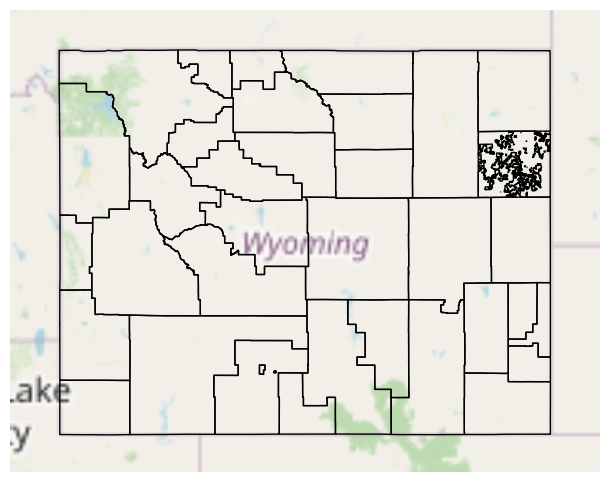

In [9]:
# Convert dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru1 = dfru1[dfru1['Geometry'] != ""].reset_index(drop=True)
dfru1['Geometry'] = gpd.GeoSeries.from_wkt(dfru1['Geometry'], crs="EPSG:4326")
gdfru1 = gpd.GeoDataFrame(dfru1, geometry=dfru1['Geometry'], crs="EPSG:4326") # covert to geodataframe
gplt.polyplot(gdfru1, ax=ax)

In [10]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe

dfs1 = dfs.copy()
#nameOfWaterSourceTypeCV= "Surface and Groundwater" # change here for WaterSourceTypeCV of interest
dfs1 = dfs1[(dfs1['WaterSourceTypeCV'] == 'Groundwater') | (dfs1['WaterSourceTypeCV'] == 'Surface Water')]
dfs1 = dfs1[dfs1['PODorPOUSite'] == 'POD']
print(len(dfs1))
print(dfs1['WaterSourceTypeCV'].unique())
dfs1.head(1)

119629
['Groundwater' 'Surface Water']


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WYwr_SwadeID1,NaN,WYwr_WSwadeID1,WaDE Blank,WaDE Blank,WaDE Blank,4326,NaN,NaN,NaN,NaN,42.91290,-104.46127,NaN,NaN,POD,O W Well #1,wadeID1,NaN,Well,WY,NaN,WYwr_WSwadeID1,Groundwater


<GeoAxesSubplot: >

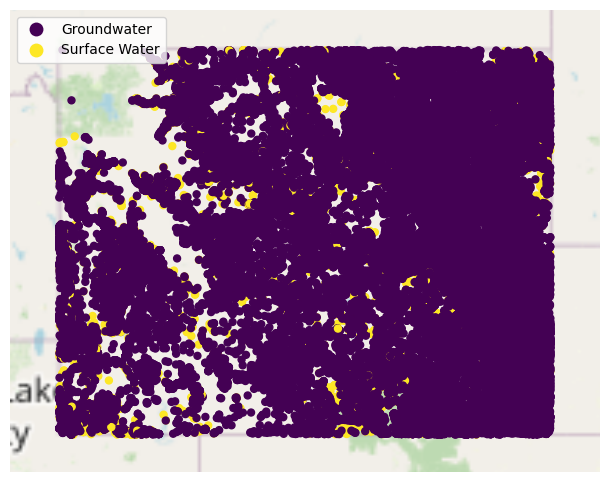

In [11]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs1 = gpd.GeoDataFrame(dfs1, geometry=gpd.points_from_xy(dfs1.Longitude.astype(float), dfs1.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [12]:
# Select sites within polygon.
gdfs1_ru1 = gpd.sjoin(left_df=gdfs1, right_df=gdfru1[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs1_ru1))
gdfs1_ru1.head()

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


119160


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV,geometry,index_right,ReportingUnitUUID,RegulatoryOverlayUUID
0,WYwr_SwadeID1,,WYwr_WSwadeID1,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,42.91290,-104.46127,,,POD,O W Well #1,wadeID1,,Well,WY,,WYwr_WSwadeID1,Groundwater,POINT (-104.46127 42.91290),9,WYre_RUwy18,WYre_RO18
737,WYwr_SwadeID10685,,WYwr_WSwadeID2580,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,42.94122,-104.15988,,,POD,Kraft Ditch No Two,wadeID10685,,Stream,WY,,WYwr_WSwadeID2580,Surface Water,POINT (-104.15988 42.94122),9,WYre_RUwy18,WYre_RO18
746,WYwr_SwadeID10695,,WYwr_WSwadeID2582,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,42.94619,-104.25512,,,POD,Jensen Portable Sprinkler,wadeID10695,,Stream,WY,,WYwr_WSwadeID2582,Surface Water,POINT (-104.25512 42.94619),9,WYre_RUwy18,WYre_RO18
756,WYwr_SwadeID10704,,WYwr_WSwadeID54,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,42.89289,-104.73231,,,POD,Goss No I Ditch,wadeID10704,,Stream,WY,,WYwr_WSwadeID54,Surface Water,POINT (-104.73231 42.89289),9,WYre_RUwy18,WYre_RO18
8209,WYwr_SwadeID1757,,WYwr_WSwadeID1,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,43.46289,-104.72137,,,POD,Aqua Holic Ww #1,wadeID1757,,Well,WY,,WYwr_WSwadeID1,Groundwater,POINT (-104.72137 43.46289),9,WYre_RUwy18,WYre_RO18


<GeoAxesSubplot: >

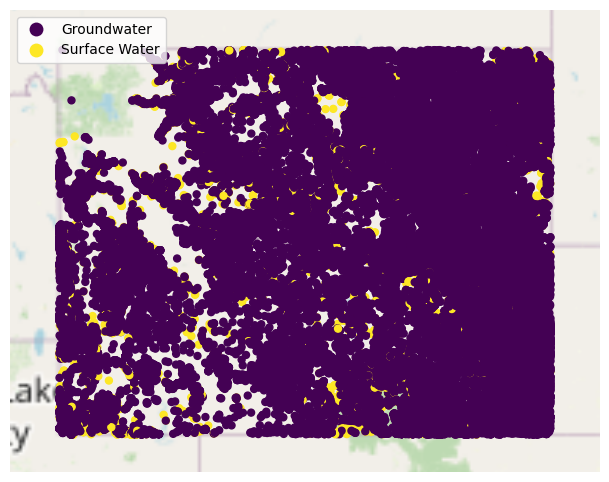

In [13]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gplt.pointplot(gdfs1_ru1, hue='WaterSourceTypeCV', legend=True, legend_var='hue', ax=ax)

In [14]:
# set RegulatoryOverlayUUIDs
gdfs1_ru1['RegulatoryOverlayUUIDs'] = gdfs1_ru1['RegulatoryOverlayUUID']
gdfs1_ru1 = gdfs1_ru1.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs1_ru1.head(1)

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID
0,WYwr_SwadeID1,WYre_RO18,WYwr_WSwadeID1,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,42.91290,-104.46127,,,POD,O W Well #1,wadeID1,,Well,WY,


#### Regulatory Area Data #2

In [15]:
# dfru2 = dfru.copy()
# etc etc

## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [16]:
# Concatenate dataframes into single output
frames = [dfs, gdfs1_ru1] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

181413


,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WSGSwr_SPOD,WYre_RO25,WSGSwr_WSwadeID1,WaDE Blank,Digitized,WaDE Blank,4326,,,,,44.670444,-107.022111,,,POD,Benen Spring No 1,POD,,Spring,WY,,WSGSwr_WSwadeID1,Groundwater


# Inspect Output Data & Export

In [17]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181413 entries, 0 to 181412
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteUUID                181413 non-null  object
 1   RegulatoryOverlayUUIDs  181413 non-null  object
 2   WaterSourceUUIDs        181413 non-null  object
 3   CoordinateAccuracy      181413 non-null  object
 4   CoordinateMethodCV      181413 non-null  object
 5   County                  181413 non-null  object
 6   EPSGCodeCV              181413 non-null  object
 7   Geometry                181413 non-null  object
 8   GNISCodeCV              181413 non-null  object
 9   HUC12                   181413 non-null  object
 10  HUC8                    181413 non-null  object
 11  Latitude                181413 non-null  object
 12  Longitude               181413 non-null  object
 13  NHDNetworkStatusCV      181413 non-null  object
 14  NHDProductCV            181413 non-n

In [18]:
outdfs

,SiteUUID,RegulatoryOverlayUUIDs,WaterSourceUUIDs,CoordinateAccuracy,CoordinateMethodCV,County,EPSGCodeCV,Geometry,GNISCodeCV,HUC12,HUC8,Latitude,Longitude,NHDNetworkStatusCV,NHDProductCV,PODorPOUSite,SiteName,SiteNativeID,SitePoint,SiteTypeCV,StateCV,USGSSiteID,WaterSourceUUID,WaterSourceTypeCV
0,WSGSwr_SPOD,WYre_RO25,WSGSwr_WSwadeID1,WaDE Blank,Digitized,WaDE Blank,4326,,,,,44.670444,-107.022111,,,POD,Benen Spring No 1,POD,,Spring,WY,,WSGSwr_WSwadeID1,Groundwater
1,WSGSwr_SPODA1000G,WYre_RO14,WSGSwr_WSwadeID1,WaDE Blank,Digitized,WaDE Blank,4326,,,,,43.00243,-108.3777,,,POD,WaDE Blank,PODA100.0G,,Well,WY,,WSGSwr_WSwadeID1,Groundwater
2,WSGSwr_SPODA100G,WYre_RO21,WSGSwr_WSwadeID1,WaDE Blank,Digitized,WaDE Blank,4326,,,,,43.11927,-109.0062,,,POD,WaDE Blank,PODA10.0G,,Well,WY,,WSGSwr_WSwadeID1,Groundwater
3,WSGSwr_SPODA1010G,WYre_RO14,WSGSwr_WSwadeID1,WaDE Blank,Digitized,WaDE Blank,4326,,,,,42.99207,-108.42714,,,POD,WaDE Blank,PODA101.0G,,Well,WY,,WSGSwr_WSwadeID1,Groundwater
4,WSGSwr_SPODA1020G,WYre_RO21,WSGSwr_WSwadeID1,WaDE Blank,Digitized,WaDE Blank,4326,,,,,43.03456,-108.76136,,,POD,WaDE Blank,PODA102.0G,,Well,WY,,WSGSwr_WSwadeID1,Groundwater
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181408,WYwr_SwadeID9995,WYre_RO21,WYwr_WSwadeID161,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,42.860419,-108.920022,,,POD,Enl Brown Jug Ditch,wadeID9995,,Stream,WY,,WYwr_WSwadeID161,Surface Water
181409,WYwr_SwadeID9996,WYre_RO24,WYwr_WSwadeID2255,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,41.65175,-106.65567,,,POD,Spring Ditch,wadeID9996,,Spring,WY,,WYwr_WSwadeID2255,Surface Water
181410,WYwr_SwadeID9997,WYre_RO15,WYwr_WSwadeID855,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,41.78803,-106.43469,,,POD,Producers And Refiners Corporation Water Line,wadeID9997,,Spring,WY,,WYwr_WSwadeID855,Surface Water
181411,WYwr_SwadeID9998,WYre_RO24,WYwr_WSwadeID581,WaDE Blank,WaDE Blank,WaDE Blank,4326,,,,,41.601606,-106.604242,,,POD,Mesa No 2 Ditch,wadeID9998,,Spring,WY,,WYwr_WSwadeID581,Surface Water


In [20]:
# Export out to CSV.
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder